<a href="https://colab.research.google.com/github/narendra974/NLPTransferLearning/blob/main/Deu_Gen_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/DATASETS/ENG_DEU_DATA/

/content/drive/MyDrive/DATASETS/ENG_DEU_DATA


In [3]:
%ls

commoncrawl_de_en.txt  europarl-v7_de_en.txt  news-commentary-v9_de_en.txt
commoncrawl_en_de.txt  europarl-v7_en_de.txt  news-commentary-v9_en_de.txt


In [4]:
import pandas as pd

def file_to_df(filename):
  with open(filename, "rb") as file_open:
    lines = file_open.readlines()

  return pd.DataFrame(lines)

In [5]:
df_cc_de = file_to_df("commoncrawl_de_en.txt")
df_cc_en = file_to_df("commoncrawl_en_de.txt")
df_eu_de = file_to_df("europarl-v7_de_en.txt")
df_eu_en = file_to_df("europarl-v7_en_de.txt")
df_nc_de = file_to_df("news-commentary-v9_de_en.txt")
df_nc_en = file_to_df("news-commentary-v9_en_de.txt")

In [6]:
print(df_cc_de.shape)
print(df_cc_en.shape)
print(df_eu_de.shape)
print(df_eu_en.shape)
print(df_nc_de.shape)
print(df_nc_en.shape)

(2399123, 1)
(2399123, 1)
(1920209, 1)
(1920209, 1)
(201288, 1)
(201288, 1)


In [7]:
data_de = pd.concat([df_cc_de, df_eu_de, df_nc_de], axis=0)
data_en = pd.concat([df_cc_en, df_eu_en, df_nc_en], axis=0)
print(data_de.shape)
print(data_en.shape)

(4520620, 1)
(4520620, 1)


In [8]:
data_de.columns = ["German"]
data_en.columns = ["English"]
print(data_de.columns)
print(data_en.columns)

Index(['German'], dtype='object')
Index(['English'], dtype='object')


In [9]:
data_de["German"] = data_de["German"].str.decode("utf-8")
data_en["English"] = data_en["English"].str.decode("utf-8")

In [16]:
data_en['eng_len'] = data_en.English.apply(len)
data_de['ger_len'] = data_de.German.apply(len)

<ipython-input-17-e81029dee227>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_en.eng_len,ax=axes[0])
<ipython-input-17-e81029dee227>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_de.ger_len,ax=axes[1])


<Axes: xlabel='ger_len', ylabel='Density'>

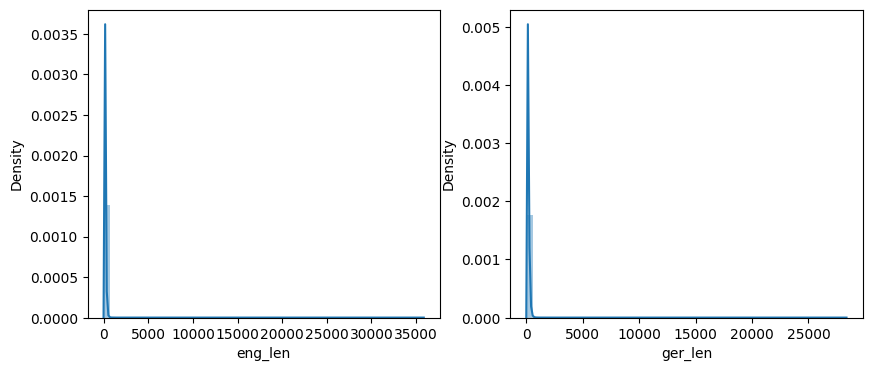

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.distplot(data_en.eng_len,ax=axes[0])
sns.distplot(data_de.ger_len,ax=axes[1])

In [23]:
data_en.describe(percentiles=[.1, .2, .3, .4, .5, .6 , .7, .8, .9, .95, .98, .99, 1])

,eng_len
count,4.520620e+06
mean,1.366846e+02
std,9.605065e+01
min,0.000000e+00
10%,5.100000e+01
20%,6.900000e+01
30%,8.500000e+01
40%,1.010000e+02
50%,1.190000e+02
60%,1.380000e+02


In [25]:
data_de.describe(percentiles=[.1, .2, .3, .4, .5, .6 , .7, .8, .9, .95, .98, .99, 1])

,ger_len
count,4.520620e+06
mean,1.648038e+02
std,9.864190e+01
min,1.400000e+01
10%,7.100000e+01
20%,9.100000e+01
30%,1.080000e+02
40%,1.260000e+02
50%,1.450000e+02
60%,1.660000e+02


In [10]:
max_seq_len = 512

In [11]:
import re

def clean_text(text):
    text = text.lower()
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    return text

In [12]:
data_en.English = data_en.English.apply(clean_text)
data_de.German = data_de.German.apply(clean_text)

In [13]:
data_de.German = data_de.German.apply(lambda x: '<START> ' + x + ' <END>')

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(data_en.English)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_sequences = eng_tokenizer.texts_to_sequences(data_en.English)
eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_seq_len, dtype='int32', padding='post', truncating='post')

In [15]:
ger_tokenizer = Tokenizer()
ger_tokenizer.fit_on_texts(data_de.German)
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_sequences = ger_tokenizer.texts_to_sequences(data_de.German)
ger_pad_sequences = pad_sequences(ger_sequences,maxlen=max_seq_len, dtype='int32', padding='post', truncating='post')